In [ ]:
!pip3 install seqeval

In [2]:
pip install tensorflow

In [3]:
 import pandas as pd
annotations = pd.read_csv("chap4_mahabharath_annotations.csv", index_col=['id'])

In [4]:
annotations

,sentence#,token,tag
id,,,
0,0,Om,CONCEPT
1,0,!,O
2,1,Having,O
3,1,bowed,O
4,1,down,O
...,...,...,...
830510,34331,The,O
830511,34331,end,O
830512,34331,of,O


In [5]:
words = list(annotations['token'].values)
words.append('PADword')
n_words = len(set(words))
n_words, len(words)

(19573, 830516)

In [6]:
tags = list(set(annotations["tag"].values))
n_tags = len(tags)
print(n_tags)
tags

12


['BOOK',
 'PLANT',
 'PLACE',
 'GROUP',
 'O',
 'SPECIAL_OBJECT',
 'CONCEPT',
 'TITLE',
 'PERSON',
 'WEAPON',
 'ANIMAL',
 'WATER']

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(annotations)
sent = getter.get_next()
print(sent)

[('Om', 'CONCEPT'), ('!', 'O')]


In [9]:
sentences = getter.sentences
print(len(sentences))

34332


In [10]:
sentences[0][0][1]

'CONCEPT'

In [11]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 428 words


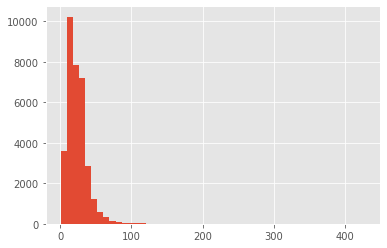

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [13]:
max_len = 50
X = [[w[0] for w in s] for s in sentences]
Y = [[w[1] for w in s] for s in sentences]
new_X = []
y_label = []
for k in range(len(X)):
    seq = X[k]
    j = 0
    while(j<len(seq)):
        new_seq = []
        new_y = []
        for i in range(j,j+max_len):
            try:
                new_seq.append(seq[i])
                new_y.append(Y[k][i])
            except:
                new_seq.append("PADword")
                new_y.append('O')
        new_X.append(new_seq)
        y_label.append(new_y)
        j=i+1

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

living_entity_tags = ['ANIMAL','PERSON','GROUP','TITLE']
non_living_entity_tags = ['BOOK','PLACE','WEAPON','SPECIAL_OBJECT','PLANT','CONCEPT','WATER']

#for extraction of entities
tags2index = {}
for tag in tags:
    if tag not in living_entity_tags and tag not in non_living_entity_tags:
        tags2index[tag] = 0
    elif tag in living_entity_tags:
        tags2index[tag] = 1
    else:
        tags2index[tag] = 2
        
# tags2index = {t:i for i,t in enumerate(tags)}
y=[]        
for labels in y_label:
    word_tag = []
    for label in labels:
#         print(label)
        word_tag.append(tags2index[label])
    y.append(np.array(word_tag))
tags2index

{'ANIMAL': 1,
 'BOOK': 2,
 'CONCEPT': 2,
 'GROUP': 1,
 'O': 0,
 'PERSON': 1,
 'PLACE': 2,
 'PLANT': 2,
 'SPECIAL_OBJECT': 2,
 'TITLE': 1,
 'WATER': 2,
 'WEAPON': 2}

In [15]:
y = np.array(y)

In [16]:
y[0], new_X[0]

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 ['Om',
  '!',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword'])

In [17]:
pip install transformers

     |████████████████████████████████| 2.3MB 27.5MB/s 
     |████████████████████████████████| 3.3MB 47.2MB/s 
     |████████████████████████████████| 901kB 30.1MB/s 


In [18]:
len(new_X)

36078

In [19]:
import keras
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import add, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda,concatenate
import seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [20]:
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)
batch_size = 32

In [21]:
from transformers import RobertaTokenizer
roberta = 'roberta-large'

tokenizer = RobertaTokenizer.from_pretrained(roberta, do_lower_case=True, add_special_tokens=True,
                                                max_length=max_len, pad_to_max_length=True)

In [22]:
 def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for i in range(len(sentences)):
      inputs = tokenizer.encode_plus(sentences[i], add_special_tokens=True, max_length=max_len, padding=True, 
                                             return_attention_mask=True, return_token_type_ids=True,truncation=True)
      input_ids.append(inputs['input_ids'])
      input_masks.append(inputs['attention_mask'])
      input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids), np.asarray(input_masks), np.asarray(input_segments)


In [23]:
len(X_tr), len(X_te), batch_size,len(X_tr)/batch_size, len(X_te)/batch_size 

(32470, 3608, 32, 1014.6875, 112.75)

In [24]:
X_tr, X_val = X_tr[:914*batch_size], X_tr[-100*batch_size:]
y_tr, y_val = y_tr[:914*batch_size], y_tr[-100*batch_size:]
#y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
#y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [25]:
X_tr_in,X_tr_mask,_ = np.array(tokenize(X_tr,tokenizer))
X_val_in,X_val_mask,_ = np.array(tokenize(X_val,tokenizer))
X_te_in,X_te_mask,_ = np.array(tokenize(X_te,tokenizer))
#y_tr_in,y_tr_mask,_ = np.array(tokenize(y_tr,tokenizer))
#y_val_in,y_val_mask,_ = np.array(tokenize(y_val,tokenizer))

In [26]:
from transformers import TFRobertaModel, RobertaConfig

In [27]:
config = RobertaConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFRobertaModel.from_pretrained(roberta)

input_ids_in=tf.keras.layers.Input(shape=(max_len,),name='input_token',dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_len,),name='masked_token',dtype='int32')
#input_segments_in = tf.keras.layers.Input(shape=(max_len,),name='segment_token',dtype='int32')

embedding_layer = transformer_model([input_ids_in,input_masks_in])[0]
#cls_token = embedding_layer[:,0,:]
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding_layer)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2) )(x)
x = add([x, x_rnn])  
#x = Dense(2056,activation='relu')(x)
out = TimeDistributed(Dense(3, activation="softmax"))(x)
model = Model([input_ids_in,input_masks_in], out)

for layer in model.layers[:3]:
  layer.trainable = False

model.summary()

Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [28]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [29]:
pip install livelossplot

In [30]:
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [PlotLossesKeras(),early_stopping]

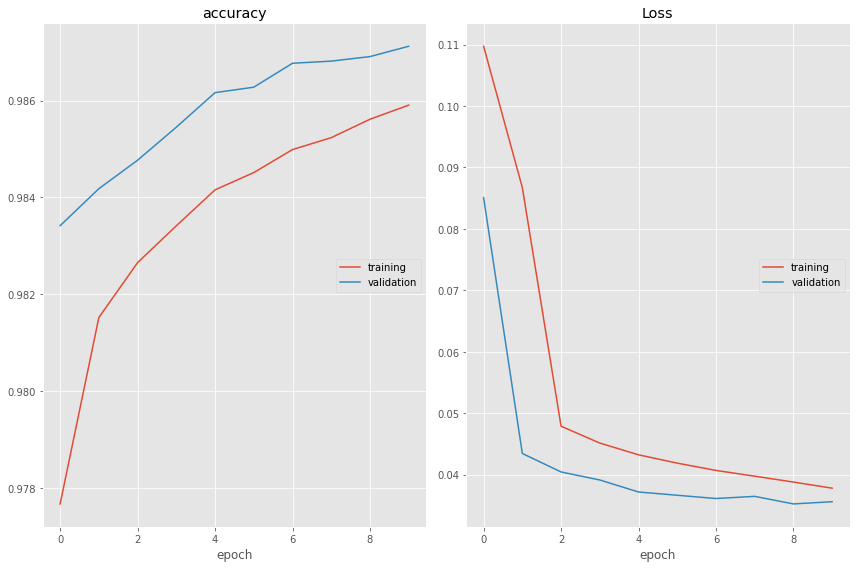

accuracy
	training         	 (min:    0.978, max:    0.986, cur:    0.986)
	validation       	 (min:    0.983, max:    0.987, cur:    0.987)
Loss
	training         	 (min:    0.038, max:    0.110, cur:    0.038)
	validation       	 (min:    0.035, max:    0.085, cur:    0.036)


In [31]:
history = model.fit([X_tr_in,X_tr_mask],y_tr,
                    validation_data=([X_val_in,X_val_mask],y_val),
                    batch_size=batch_size, 
                    epochs=10,
                    callbacks=[callbacks], 
                    verbose=1)

In [32]:
X_te = X_te[:112*batch_size]
y_te = y_te[:112*batch_size]
X_te_in,X_te_mask,_ = np.array(tokenize(X_te,tokenizer))


In [33]:
preds = model.predict([X_te_in,X_te_mask], verbose=1, batch_size=batch_size)

112/112 [==============================] - 46s 383ms/step


In [34]:
# in case of classification
# idx2tag = {i: w for w, i in tags2index.items()}

# in case of extraction of entities
idx2tag = {}
for k,v in tags2index.items():
    if v == 0:
        idx2tag[v] = 'O'
    elif v == 1:
        idx2tag[v] = "LIVING"
    else:
        idx2tag[v] = " NON-LIVING"
        
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out

In [35]:
pred_labels = pred2label(preds)

In [36]:
np.array(pred_labels).shape

(3584, 50)

In [37]:
preds.shape

(3584, 50, 3)

In [38]:
y_te.shape

(3584, 50)

In [39]:
test_labels = test2label(y_te)

In [40]:
np.array(test_labels).shape

(3584, 50)

In [41]:
print(classification_report(pred_labels, test_labels))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:  NON-LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

       IVING       0.58      0.81      0.68      2773
      LIVING       0.31      0.71      0.43       269

   micro avg       0.55      0.80      0.65      3042
   macro avg       0.44      0.76      0.55      3042
weighted avg       0.56      0.80      0.66      3042



In [42]:
print(f1_score(pred_labels, test_labels,average='micro'))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:  NON-LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0.6488356620093148
